In [81]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [66]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [67]:
# Drop ID column

df.drop(columns=["customerID"], inplace=True)

In [68]:
# Convert TotalCharges object into numeric

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [69]:
np.sum(df.isnull(),axis=0)

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [70]:
df['TotalCharges'] =df["TotalCharges"].fillna(df["TotalCharges"].median())

In [71]:
# Make classification target as 0 and 1

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

Binary categorical (Yes/No, Male/Female)  -> Encode as 0 / 1
* gender
* Partner
* Dependents
* PhoneService
* PaperlessBilling

In [72]:
pd.set_option('future.no_silent_downcasting', True)

binary_cols = [
    "gender", "Partner", "Dependents",
    "PhoneService", "PaperlessBilling"
]

df[binary_cols] = df[binary_cols].replace({
    "Yes": 1, "No": 0,
    "Male": 1, "Female": 0
})

Multi category columns -> One Hot encode

In [73]:
multi_cat_cols = [
    "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport",
    "StreamingTV", "StreamingMovies",
    "Contract", "PaymentMethod"
]

In [74]:
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

In [75]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,False,False,False,False,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,False,False,False,False,False,False,False,False,True,False


In [76]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [77]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [78]:
X_train.shape, X_test.shape

((5634, 30), (1409, 30))

In [82]:
def model_builder(hp):
  model = keras.Sequential()

  # Input layer
  model.add(keras.Input(shape=(X_train.shape[1],)))

  for i in range(hp.Int('num_layers', 1, 5)):
    units = hp.Int(f'units_{i}', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=units, activation='relu'))

  # Output layer
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

In [83]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [84]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [86]:
tuner.search(X_train, y_train, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)

Best hyperparameters: {'num_layers': 2, 'units_0': 512, 'learning_rate': 0.01, 'units_1': 448, 'units_2': 96, 'units_3': 128, 'units_4': 160, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0054'}


In [87]:
model = model_builder(best_hyperparameters)

history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[stop_early]
)

model.save("churn_model.keras")

Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7890 - loss: 0.4686 - val_accuracy: 0.7828 - val_loss: 0.4400
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7925 - loss: 0.4370 - val_accuracy: 0.7942 - val_loss: 0.4576
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7978 - loss: 0.4322 - val_accuracy: 0.7850 - val_loss: 0.4381
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8019 - loss: 0.4263 - val_accuracy: 0.7949 - val_loss: 0.4265
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8090 - loss: 0.4184 - val_accuracy: 0.7842 - val_loss: 0.4470
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8092 - loss: 0.4173 - val_accuracy: 0.7949 - val_loss: 0.4353
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8110 - loss: 0.4107 - val_accuracy: 0.7970 - val_loss: 0.4352
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8147 - loss: 0.4112 - val_accuracy: 0.

In [88]:
from tensorflow import keras

# Load the saved model
loaded_model = keras.models.load_model("churn_model.keras")

* Use loaded model to do predictions

In [89]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Predict probabilities
y_pred_prob = loaded_model.predict(X_test)

# Convert probabilities to 0/1 labels
y_pred = (y_pred_prob > 0.5).astype(int)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [90]:
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

Test Accuracy: 0.794889992902768


In [95]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.65      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.79      1409



According to the recall value, the model is more bias to calssify as "Not churn" because of more training data samples are not churn values.

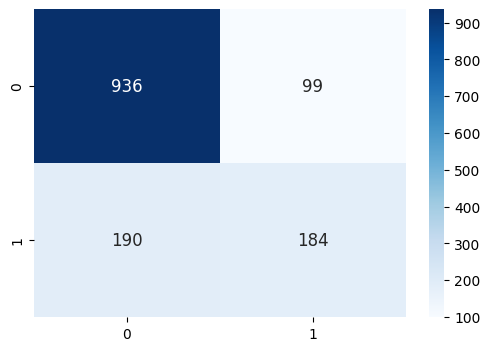

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

cf = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cf, annot=True, cmap="Blues", fmt='d', annot_kws={"size": 12}) #
plt.show()


In [97]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred_prob)

0.8410938024748766

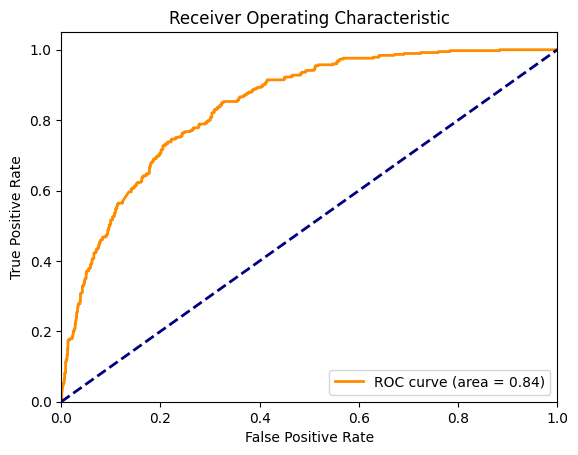

In [94]:
# ROC curve

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()